In [47]:
import csv
import glob
import os
import re

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [49]:
from collections import defaultdict

In [50]:
bam_name2site = dict()

In [51]:
with open("../data/lin2014/meta_data.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for row in reader:
        site, _, bam_path, _ = row
        
        bam_name = re.search(r'ENC\w+', bam_path).group(0)
        bam_name2site[bam_name] = site

In [52]:
gained_meta_fe = set()

In [53]:
meta_fe_ss_no = defaultdict(lambda: 0)

In [54]:
meta_fe2ss = defaultdict(set)
ss2meta_fe = dict()

In [55]:
with open("../data/ref/homo_sapiens/annot/out/meta_exon.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for row in reader:
        gene, gene_func, chrom, meta_beg, meta_end, strand, meta_type, make_up = row

        if meta_type != "FE" or gene_func != "protein_coding":
            continue

        make_up = make_up.split(",")
        
        strand = int(strand == "+")
        meta_exon = f"{chrom}:{meta_beg}-{meta_end}:{strand}"
        
        for exon in make_up:
            _, beg, end = re.split('[=-]', exon)
            
            if strand == 1:
                ss = f"{chrom}:{end}:{strand}"
            else:
                ss = f"{chrom}:{beg}:{strand}"
                
            meta_fe2ss[meta_exon].add(ss)
            ss2meta_fe[ss] = meta_exon

In [56]:
gained_fe_ss_count = defaultdict(lambda: 0)

In [57]:
N = 0
t = 0

In [58]:
with open("../data/homology/ss/out/origin.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)
    
    for row in reader:
        gene, meta_exon, p, pos, _, gain_ages, loss_ages, pos_group, neg_group, tree_size, _ = row

        if ";" in gain_ages or int(tree_size) < 3:
            # `";" in gain_ages` indicates more than one gain event, which
            # we've opted to exclude.
            continue
        
        neg_group = set(re.findall(r'(?<==)\w{2}(?=[;=])', neg_group))
        hsap_kind = re.search(r'(?<=homo_sapiens=)\wE', pos_group).group(0)
        
        if neg_group == {"NE"} or hsap_kind != "FE":
            continue
            
        chrom, beg, _, strand = re.split('[:-]', pos)
        junk = int(beg) + 50
        
        if f"{chrom}:{junk}:{strand}" not in ss2meta_fe:
            continue
            
        if gain_ages == "homo_sapiens":
            age = 0
        else:
            age = float(gain_ages)
            
        if age < 20:
            age = "<20"
        elif 20 < age < 90:
            age = "20–90"
        else:
            age = ">90"

        meta_fe = ss2meta_fe[f"{chrom}:{junk}:{strand}"]
        meta_fe_ss = meta_fe2ss[meta_fe]
        
        ss_count = len(meta_fe_ss)
        gained_fe_ss_count[ss_count] += 1        
        
        # if ss_count > 1:
        gained_meta_fe.add((meta_fe, f"{chrom}:{junk}:{strand}", age))

In [60]:
data = []

In [61]:
for path in glob.iglob("data/lin2014/out/*.csv"):
    name = os.path.basename(path)[:-4]
    site = bam_name2site[name]
    
    edge5_count = dict()
    
    with open(path, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        
        for row in reader:
            p, chrom, edge, strand, _, score, count = row
            
            if score == "*" or float(score) < 0 or int(p) == 3:
                continue
                
            strand = int(strand == "+")
            chrom = chrom[3:]
            
            edge5_count[f"{chrom}:{edge}:{strand}"] = int(count)
            
    for meta_fe, gained_ss, age in gained_meta_fe:
        if len(meta_fe2ss[meta_fe]) == 2:
            continue
        
        n_count = edge5_count.get(gained_ss, 0)
        o_count = sum([edge5_count.get(ss, 0) for ss in meta_fe2ss[meta_fe] if ss != gained_ss])
        
        if o_count == 0:
            continue
            
        data.append({
            'name': name,
            'site': site,
            'usage': n_count / (n_count + o_count),
            'age': age
        })

In [62]:
frame = pd.DataFrame(data)

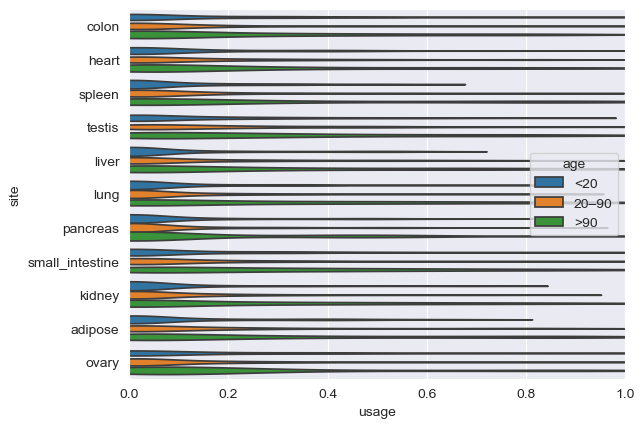

In [63]:
sns.violinplot(frame, x='usage', y='site', hue='age', hue_order=["<20", "20–90", ">90"], inner=None)
_ = plt.xlim(0, 1)

plt.savefig("figs/main_5a.pdf")